# Trabajo Práctico N°1 Aprendizaje Automático 1#
## Integrantes ##
1. López Ceratto, Julieta : L-3311/1
2. Rodríguez Griñó, Tomás : R-4643/4
3. Slepoy, David: S-5782/7

Importamos librerías necesarias

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn import metrics
import warnings
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
warnings.filterwarnings("ignore")
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score

# PUNTO 1


In [2]:
old_df = pd.read_csv('src\weatherAUS.csv', sep = ',')

In [3]:
old_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Realizamos una linea de codigo en la cual se eligen 10 ciudades aleatorias. Con estas mismas se trabajara en todo el trabajo practico

In [4]:
unique_locations = old_df['Location'].unique()

# Seleccionar aleatoriamente 10 ciudades
selected_cities = pd.Series(unique_locations).sample(n=10, random_state=42).tolist()

# Filtrar el DataFrame para quedarnos solo con las ciudades seleccionadas
df = old_df[old_df['Location'].isin(selected_cities)]

# Mostrar las primeras filas del DataFrame filtrado
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
39538,2009-01-01,Williamtown,15.2,34.0,0.0,11.6,9.2,NW,41.0,WNW,...,62.0,36.0,1005.2,1001.5,3.0,6.0,23.7,28.7,No,No
39539,2009-01-02,Williamtown,18.3,24.5,0.0,8.8,9.4,S,54.0,S,...,61.0,57.0,1012.1,1011.7,3.0,2.0,21.6,23.4,No,No
39540,2009-01-03,Williamtown,16.8,23.5,0.4,8.4,0.4,NE,37.0,ESE,...,60.0,58.0,1020.4,1018.4,7.0,7.0,20.1,21.7,No,No
39541,2009-01-04,Williamtown,17.5,27.8,0.0,5.0,12.0,E,50.0,NE,...,60.0,51.0,1018.4,1014.6,1.0,1.0,22.7,26.4,No,No
39542,2009-01-05,Williamtown,14.8,36.0,0.0,8.6,11.9,ENE,37.0,NNW,...,67.0,39.0,1013.6,1008.7,2.0,3.0,22.5,33.8,No,No


## Datos Faltantes

In [5]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64

## Eliminamos las filas donde los datos faltantes son null en la variable a predecir

In [6]:
df['RainTomorrow'].isnull().sum() / len(df)

0.0253696119941695

In [7]:
df = df.dropna(subset=['RainTomorrow'])

In [8]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            130
MaxTemp             45
Rainfall           331
Evaporation       9614
Sunshine         13542
WindGustDir        535
WindGustSpeed      533
WindDir9am        2127
WindDir3pm         384
WindSpeed9am       201
WindSpeed3pm       192
Humidity9am        702
Humidity3pm       1267
Pressure9am       4092
Pressure3pm       4091
Cloud9am         10530
Cloud3pm         11281
Temp9am            473
Temp3pm            969
RainToday          331
RainTomorrow         0
dtype: int64

## Agregamos columnas 'Dia-del-año', 'Mes' y "Estación"
Estas columnas corresponden al día, mes y estación del año, se utilizará mas adelante

In [9]:
#Primero convertimos el tipo de dato de Date a fecha
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df['Date']

39538    2009-01-01
39539    2009-01-02
39540    2009-01-03
39541    2009-01-04
39542    2009-01-05
            ...    
143875   2017-06-19
143876   2017-06-20
143877   2017-06-21
143878   2017-06-22
143879   2017-06-23
Name: Date, Length: 28083, dtype: datetime64[ns]

In [11]:
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month

In [12]:
df['Day_of_Year'] 

39538       1
39539       2
39540       3
39541       4
39542       5
         ... 
143875    170
143876    171
143877    172
143878    173
143879    174
Name: Day_of_Year, Length: 28083, dtype: int32

Chequeamos que se hayan hecho bien las divisiones

In [13]:
def obtener_estacion(mes):
    '''
    Esta función devuelve una estación dado un mes.
    '''
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    elif mes in [9, 10, 11]:
        return 'Primavera'
    
df['Season'] = df['Month'].apply(obtener_estacion)

In [14]:
df['Season'].unique()

array(['Verano', 'Otoño', 'Invierno', 'Primavera'], dtype=object)

## Division del conjunto de datos 

In [15]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Day_of_Year', 'Month',
       'Season'],
      dtype='object')

In [16]:
# Definir X e y
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']

Quitamos Date del conjunto ya que no es necesaria

In [17]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.3, random_state= 41, shuffle=False)

### Datos faltantes ###

In [18]:
X_train.isnull().sum()

Location            0
MinTemp            80
MaxTemp            19
Rainfall          294
Evaporation      5941
Sunshine         7593
WindGustDir       404
WindGustSpeed     403
WindDir9am       1002
WindDir3pm        288
WindSpeed9am      193
WindSpeed3pm      175
Humidity9am       456
Humidity3pm       272
Pressure9am      2944
Pressure3pm      2937
Cloud9am         5975
Cloud3pm         5941
Temp9am           431
Temp3pm           250
RainToday         294
Day_of_Year         0
Month               0
Season              0
dtype: int64

Podemos ver que en varias columnas hay datos faltantes.


Primero vemos que no haya columnas duplicadas.


In [19]:
X_train.duplicated().sum()

0

## Imputación de datos faltantes ##


Los valores nulos tendremos que tratarlos de columna en columna

In [20]:
X_train.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
Day_of_Year        int32
Month              int32
Season            object
dtype: object

### Obtenemos media y moda para los datos segun el mes

In [21]:
# Función para aplicar mediana a columnas numéricas y moda a las no numéricas
def mediana_moda(grupo):
    '''
    Obtiene la mediana y moda según el tipo de dato, dado
    un grupo específico de datos.
    '''
    # Para las columnas numéricas aplicamos la mediana
    numericas = grupo.select_dtypes(include='number').median()
    
    # Para las columnas no numéricas aplicamos la moda
    no_numericas = grupo.select_dtypes(exclude='number').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Combinar resultados
    return pd.concat([numericas, no_numericas])

In [22]:
## Obtenemos mediana y moda según la columna por mes para el conjunto Train
medianas = X_train.groupby('Month').apply(mediana_moda)

In [23]:
medianas

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp9am,Temp3pm,Day_of_Year,Month,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,Season
Month,,,,,,,,,,,,,,,,,,,,,
1,13.9,25.60,0.0,7.2,10.1,41.0,13.0,19.0,67.0,49.0,...,17.9,23.6,16.0,1.0,Bendigo,SSW,SE,SW,No,Verano
2,13.9,25.50,0.0,6.0,9.0,39.0,13.0,17.0,74.0,51.0,...,17.4,23.7,46.0,2.0,Watsonia,SSE,SSE,SE,No,Verano
3,12.3,23.20,0.0,4.6,7.7,37.0,11.0,17.0,80.0,54.0,...,15.6,21.7,75.0,3.0,Bendigo,W,SE,W,No,Otoño
4,9.7,19.50,0.0,3.0,6.1,35.0,11.0,15.0,80.0,59.0,...,14.0,18.2,106.0,4.0,Bendigo,SSE,WNW,SSW,No,Otoño
5,7.1,15.90,0.2,1.6,4.5,35.0,13.0,15.0,87.0,64.0,...,10.9,14.9,136.0,5.0,Portland,WNW,WNW,W,No,Otoño
6,5.1,13.90,0.2,1.2,4.3,35.0,11.0,15.0,92.0,70.0,...,8.6,12.9,166.0,6.0,Bendigo,N,WNW,WNW,No,Invierno
7,5.3,13.15,0.4,1.4,4.5,39.0,13.0,17.0,91.0,70.0,...,8.4,12.3,197.0,7.0,Bendigo,N,N,N,No,Invierno
8,5.5,14.00,0.2,2.2,6.0,41.0,15.0,19.0,83.0,63.0,...,9.4,12.9,228.0,8.0,Bendigo,W,WNW,W,No,Invierno
9,6.7,16.00,0.0,3.0,6.9,43.0,15.0,19.0,73.0,57.0,...,11.4,14.6,259.0,9.0,Bendigo,WNW,W,WNW,No,Primavera


### Llenamos datos faltantes segun el valor de mediana o moda que le corresponda al mes

In [24]:
def llenar_faltantes_por_mes(fila, df_mediana_moda):
    '''
    Dado una fila y los valores de media y moda para cada columna y mes,
    llena los datos faltantes de dicha fila
    '''
    mes = fila['Month']
    
    # Iterar sobre las columnas del DataFrame
    for columna in fila.index:
        # Si el valor es nulo, llenarlo con la mediana o moda del mes
        if pd.isnull(fila[columna]):
            if columna in df_mediana_moda.columns:
                fila[columna] = df_mediana_moda.loc[mes, columna]  # Usar la mediana o moda según el tipo
    return fila

In [25]:
### Rellenemos los datos faltantes de todos los conjuntos
### según los valores de mediana y moda por mes y columna
### obtenidos para el conjunto Train.
X_train = X_train.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_val = X_val.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_test = X_test.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)

In [26]:
### Quitamos las columnas categóricas mes y season 
### agregadas al principio ya que no serán necesarias posteriormente.
X_train.drop(columns= ['Month', 'Season'], inplace = True)
X_val.drop(columns= ['Month', 'Season'], inplace = True)
X_test.drop(columns= ['Month', 'Season'], inplace = True)

No se utilizó KNN vecinos ya que tiene un costo computacional muy alto.

Se eligió tratar de llenar el valor faltante de forma más adecuada posible, esto lo inferimos obteniendo la mediana o moda -según la columna- para cada mes.
El uso del mes como criterio de agrupación ayuda a capturar los patrones estacionales que pueden estar presentes en los datos climáticos.

En datos de clima, por ejemplo, las temperaturas de enero podrían ser muy diferentes a las de julio, por lo que rellenar con la mediana o moda general (sin considerar el mes) no reflejaría adecuadamente las diferencias estacionales; agrupar por mes y reemplazar según ese grupo permite que los valores faltantes se llenen con algo que es más representativo del contexto temporal del dato faltante.

Se evita así también rellenar con datos "atípicos" para un mes o estación del año en particular.

Reemplazar los valores faltantes por la mediana o moda por mes es una técnica que ayuda a preservar la integridad estacional de los datos y a minimizar el impacto de valores extremos.

Criterio explicado segun variable:

- MintTemp y MaxTemp : Se eligio reemplazar los valores nulos por la mediana a pesar de que la distrib no sea muy asimétrica.
- Rainfall : Se eligio reemplazar los valores nulos por la mediana ya que es menos sensible a valores extremos.
- Evaporation y Sunshine: Aunque pueden tener cierta asimetría, la media sigue siendo una buena estimación del valor típico. Tambien porque la evaporación y las horas de sol suelen tener una variación más gradual que la lluvia.
- WindGustDir, WindDir9am y WindDir3pm: Se eligio reemplazar los valores nulos por la moda ya que la moda representa la dirección del viento más común, que es una buena estimación para valores faltantes.
- WindGustSpeed y WindSpeed9am, WindSpeed3pm: Se eligio reeemplazar por la mediana ya que la velocidad del viento puede tener una distribución sesgada, similar a la lluvia. Y la mediana es menos afectada por valores extremos ocasionales de vientos fuertes.
- Humidity9am y Humidity3pm: Se eligio reemplazar por la mediana a pesar que la humedad suele tener una distribución más simétrica que la lluvia o el viento. Y la mediana proporciona una buena estimación del nivel de humedad típico.
- Pressure9am y Pressure3pm: Se eligio reemplazar por la media porque la presión atmosférica tiende a tener una distribución bastante simétrica y los cambios en la presión suelen ser graduales, haciendo de la media una buena representación.
- Cloud9am y Cloud3pm: Se eligio reemplazar por la mediana pues la nubosidad se mide en una escala discreta (octavos), y la mediana proporciona un valor central que es un número entero en la escala de nubosidad.
- Temp9am y Temp3pm: Se eligio reemplazar por la media pues, similarmente a MinTemp y MaxTemp, las temperaturas suelen seguir una distribución aproximadamente normal.
- RainToday : Se eligio la reemplazar por la moda porque es una variable categórica binaria (Sí/No), y la moda representa el resultado más frecuente, que es una buena estimación para un evento binario.

Verificamos que ya no haya valores nulos.

In [27]:
X_train.isnull().any()

Location         False
MinTemp          False
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustDir      False
WindGustSpeed    False
WindDir9am       False
WindDir3pm       False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday        False
Day_of_Year      False
dtype: bool

## Visualización de datos ##

Visualizamos los datos por categoría y localización.

In [28]:
# # Seleccionar solo las columnas numéricas
# numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# # Configurar el estilo de seaborn
# sns.set_style("whitegrid")

# # Calcular el número de filas y columnas para el subplot
# n_cols = 3 
# n_rows = math.ceil(len(numeric_columns) / n_cols)

# # Crear la figura y los subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
# fig.suptitle('Distribución de Variables Numéricas', fontsize=20)

# # Aplanar el array de axes si es necesario
# axes = axes.flatten() if n_rows > 1 else [axes]

# # Crear un histograma para cada variable numérica
# for i, column in enumerate(numeric_columns):
#     sns.histplot(X_train, x=column, kde=True, ax=axes[i], hue=X_train['Location'])
#     axes[i].set_title(f'Distribución de {column}', fontsize=12)
#     axes[i].set_xlabel(column, fontsize=10)
#     axes[i].set_ylabel('Frecuencia', fontsize=10)

# # Ocultar subplots vacíos
# for i in range(len(numeric_columns), len(axes)):
#     axes[i].set_visible(False)

# plt.tight_layout()
# plt.show()

# # Para variables categóricas, excluyendo 'Date' y 'Location'
# categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
# categorical_columns = [col for col in categorical_columns if col not in ['Date', 'Location']]

# # Calcular el número de filas y columnas para el subplot de variables categóricas
# n_cols_cat = 2  # Puedes ajustar esto según prefieras
# n_rows_cat = math.ceil(len(categorical_columns) / n_cols_cat)

# # Crear la figura y los subplots para variables categóricas
# fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5*n_rows_cat))

# # Aplanar el array de axes si es necesario
# axes = axes.flatten() if n_rows_cat > 1 else [axes]

# # Crear un gráfico de barras para cada variable categórica
# for i, column in enumerate(categorical_columns):
#     sns.countplot(y=column, data=X_train, ax=axes[i])
#     axes[i].set_title(f'Distribución de {column}', fontsize=12)
#     axes[i].set_xlabel('Frecuencia', fontsize=10)
#     axes[i].set_ylabel(column, fontsize=10)

# # Ocultar subplots vacíos
# for i in range(len(categorical_columns), len(axes)):
#     axes[i].set_visible(False)

# plt.tight_layout()
# plt.show()


Vemos que la variable 'Location' es importante en el modelo ya que influye en casi todas las demás variables; por lo tanto, no es una opción quitarla.

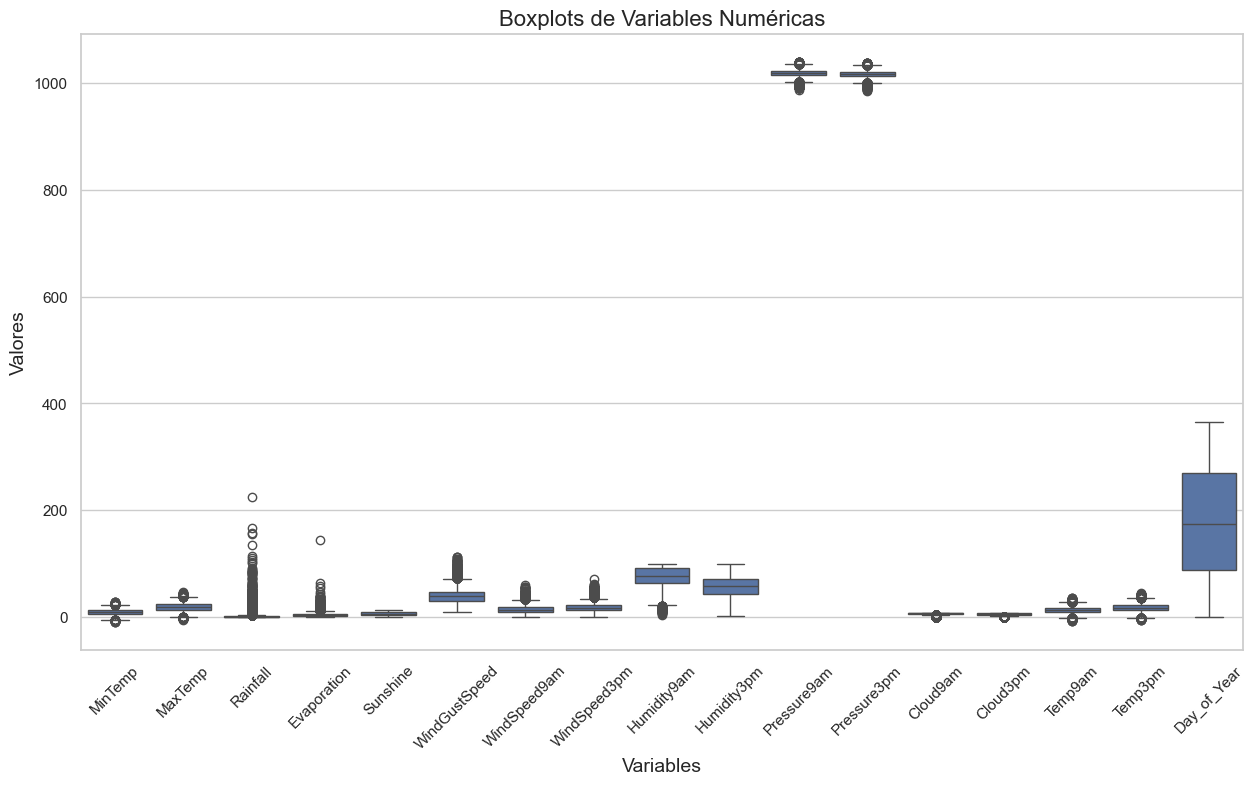

In [29]:
# Seleccionar solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Transformar el DataFrame a formato largo
X_train_melted = pd.melt(X_train, value_vars=numeric_columns)

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear boxplots para todas las columnas numéricas en un solo gráfico
plt.figure(figsize=(15, 8))
sns.boxplot(x='variable', y='value', data=X_train_melted)
plt.title('Boxplots de Variables Numéricas', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

### Descripcion de variables ###

1. MinTemp: Al ser la temperatura mínima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, ligeramente sesgada a la izquierda. La moda parece estar alrededor de los 10-15°C. Aunque no tenemos un boxplot, es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o cálidos.
2. MaxTemp: Al ser la temperatura máxima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, posiblemente con un ligero sesgo a la derecha. La moda parece estar alrededor de los 20-25°C. Es probable que haya valores atípicos en el extremo superior, representando días excepcionalmente calurosos.
3. Rainfall: Al ser la cantidad de lluvia registrada en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución fuertemente sesgada a la derecha, con una moda muy pronunciada en o cerca de 0 mm. La distribución tiene una cola larga hacia la derecha, indicando días ocasionales de lluvia intensa. Es muy probable que haya numerosos valores atípicos en el extremo superior de la distribución.
4. Evaporation: Al ser la evaporación en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores concentrados en el rango inferior. La moda parece estar cerca de 2-4 mm. Es probable que haya valores atípicos en el extremo superior, representando días con evaporación excepcionalmente alta.
5. Sunshine: Al ser el número de horas de sol brillante en el día, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución que podría ser bimodal o uniforme, reflejando la variación estacional en las horas de luz diurna. La distribución probablemente abarca desde 0 hasta 12-14 horas, con picos que podrían corresponder a los patrones de invierno y verano.
6. WindGustSpeed: Al ser la velocidad de la ráfaga de viento más fuerte en las últimas 24 horas (km/h), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores en el rango bajo a medio. La moda parece estar alrededor de 30-40 km/h. Es probable que haya valores atípicos en el extremo superior, representando ráfagas de viento excepcionalmente fuertes.
7. WindSpeed9am y WindSpeed3pm: Al ser la velocidad del viento a las 9 am y 3 pm respectivamente (km/h), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones sesgadas a la derecha, similares a WindGustSpeed pero con valores generalmente más bajos. Las modas probablemente están en el rango de 10-20 km/h. Es probable que haya valores atípicos en los extremos superiores.
8. Humidity9am y Humidity3pm: Al ser el porcentaje de humedad a las 9 am y 3 pm respectivamente, podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones que podrían ser bimodales o uniformes, abarcando un rango amplio de valores. Las modas podrían estar alrededor del 60-70% y 40-50% respectivamente. Es menos probable que haya valores atípicos extremos debido a la naturaleza limitada de la escala de porcentaje.
9. Pressure9am y Pressure3pm: Al ser la presión atmosférica a las 9 am y 3 pm respectivamente (hpa), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, centradas alrededor de 1010-1020 hpa. La variación es relativamente pequeña, reflejando la estabilidad general de la presión atmosférica. Es posible que haya algunos valores atípicos en ambos extremos, representando condiciones atmosféricas inusuales.
10. Cloud9am y Cloud3pm: Al ser la fracción de cielo cubierto por nubes a las 9 am y 3 pm respectivamente (octavos), podemos observar que son variables cuantitativas discretas. Las distribuciones probablemente muestran picos en valores específicos (0, 4, 8 octavos), reflejando la naturaleza discreta de la medición. Podría haber una ligera tendencia hacia valores más altos o más bajos dependiendo del clima local.
11. Temp9am y Temp3pm: Al ser la temperatura a las 9 am y 3 pm respectivamente (°C), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, con Temp3pm generalmente más alta y posiblemente con mayor varianza que Temp9am. Las modas probablemente están alrededor de 15-20°C para Temp9am y 20-25°C para Temp3pm. Es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o calurosos.
12. RainToday y RainTomorrow: Al ser variables categóricas binarias (Sí/No) que indican si llovió hoy o si lloverá mañana, podemos observar que son variables cualitativas nominales. La distribución muestra dos barras, una para 'Sí' y otra para 'No'. Es probable que la barra de 'No' sea significativamente más alta, indicando que los días sin lluvia son más comunes que los días con lluvia.

Además podemos observar como variables como MinTemp y Maxtemp cambian su comportamiento según la estación del año, corroborando que la decisión sobre el llenado de datos faltantes fue correcta

Se tomo la desicion de trabajar con los datos atipicos ya que
* Se preservan mejor la integridad de los datos, ya que los datos atipicos, en este dataset, pueden representar variaciones naturales en los datos, y si se ignoran o se eliminan puede llevar a una perdida de informacion valiosa
* Mejora la robustez del modelo, ya que al trabajar con estos mismos, puede ayudar a mejorar la robustez del modelo.
* Evita la perdida de informacion, pues al eliminar estos datos atipicos, puede llegar a afectar la capacidad del modelo de aprender patrones significativos.

## Balance del modelo ##

RainTomorrow
No     0.72396
Yes    0.27604
Name: proportion, dtype: float64


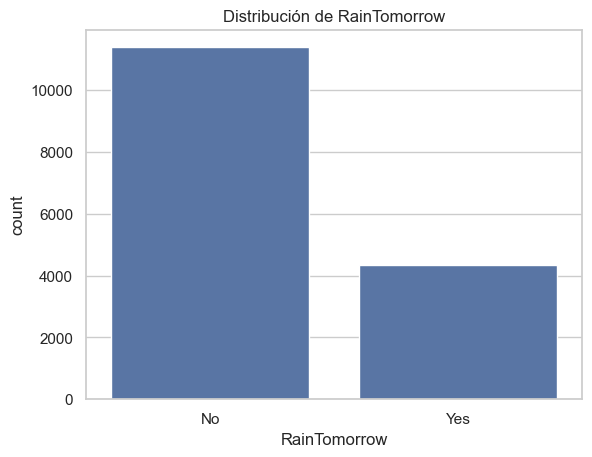

In [30]:
# Verificar el balance de la variable objetivo (RainTomorrow)
print(pd.DataFrame(y_train)['RainTomorrow'].value_counts(normalize=True))

# Visualizar el balance
sns.countplot(x='RainTomorrow', data=pd.DataFrame(y_train))
plt.title('Distribución de RainTomorrow')
plt.show()

Gracias al grafico, podemos ver que el dataset no esta balanceado, pues hay mas valores de que no va a llover, que de que si. Creemos que se hace esta pregunta para poder ver posibles problemas a futuro, como el impacto que tiene esto en el modelo.

Si no se aplican técnicas de balanceo, se puede generar un sesgo de predicción hacia la "No lluvia" ya que el modelo le asigna más penalidad el predecir mal esta variable dada su cantidad dentro del conjunto de entrenamiento, dejando con muy baja penalidad predecir mal el "Si lluvia" por su baja cantidad. Esto conduce a métricas engañosas ya que podría tener un accuracy muy alto sin significar que el modelo sea bueno.

## Codificacion de variables ##

Para codificar las variables, elegimos la representación en coordenadas polares sin-cos ya que de esta forma se disminuyen significativamente las columnas, manteniendo además la noción de 'antes' y 'después' en lo que respecta a días y de ubicación en lo que respecta a coordenadas cardenales.

In [31]:
def codificacion_localizacion(location: pd.Series) -> pd.DataFrame:
    location_to_coord = {
        'Williamtown': [-32.808996764, 151.838996644],
        'MountGinini': [-35.533, 148.783],
        'Bendigo': [-36.7581800, 144.2802400],
        'Portland': [-38.333332, 141.5999976],
        'Watsonia': [-37.69835, 145.08459],
        'Dartmoor': [-37.91439, 141.273],
        'Townsville': [-19.25762, 146.81788],
        'Launceston': [-41.43709, 147.13938],
        'AliceSprings': [-23.70021, 133.88061],
        'Katherine': [-14.46497, 132.26426]
    }
    
    # Mapea las ubicaciones a sus coordenadas
    coords = location.map(location_to_coord)
    
    # Crea un DataFrame a partir de las coordenadas
    coords_df = pd.DataFrame(coords.tolist(), columns=['Latitude', 'Longitude'])
    
    # Retorna la columna de latitud y longitud por separado
    latitude = coords_df['Latitude']
    longitude = coords_df['Longitude']    
    return latitude, longitude

In [32]:

def codificacion_coordenadas(column:pd.Series)-> pd.Series:
    '''
    Retorna dos columnas 'sin_cord' y 'cos_cord' que representan 
    en coordenadas polares la dirección cardinal.
    '''
    # Diccionario que asigna ángulos a cada dirección
    direction_to_angle = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Convertir direcciones a ángulos
    angle = column.map(direction_to_angle)

    # Convertir ángulos a radianes
    angle_rad = np.deg2rad(angle)

    # Calcular senos y cosenos y devolver una tupla (sin, cos)

    sin_cord = np.sin(angle_rad)
    cos_cord = np.cos(angle_rad)

    return sin_cord, cos_cord


In [33]:
def codificacion(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Dado dos df X e y, devuelve dos df X_encoded e y_encoded con
    sus columnas dummies codificadas por coordenadas polares

    X: conjunto x
    y: conjunto y
    '''
    x_encoded = X.copy()
    y_encoded = y.copy()

    # Codificación de la fecha en coordenadas polares según el día del año
    x_encoded['angle_day_of_year'] = (x_encoded['Day_of_Year'] / 365.0) * 2 * np.pi

    # Calcular senos y cosenos para el día del año
    x_encoded['sin_day'] = np.sin(x_encoded['angle_day_of_year'])
    x_encoded['cos_day'] = np.cos(x_encoded['angle_day_of_year'])

    # Codificación de las direcciones de viento en coordenadas polares
    x_encoded['sin_WindGustDir'], x_encoded['cos_WindGustDir'] = codificacion_coordenadas(x_encoded['WindGustDir'])
    x_encoded['sin_WindDir9am'], x_encoded['cos_WindDir9am'] = codificacion_coordenadas(x_encoded['WindDir9am'])
    x_encoded['sin_WindDir3pm'], x_encoded['cos_WindDir3pm'] = codificacion_coordenadas(x_encoded['WindDir3pm'])

    #Codificación RainToday
    x_encoded['RainToday'] = x_encoded['RainToday'].map({'Yes': 1,  'No':0})

    #Codificación Location
    latitude, longitude = codificacion_localizacion(x_encoded['Location'])
    x_encoded['Latitude'] = latitude.values
    x_encoded['Longitude'] = longitude.values
    # Convertir 'yes' a 1 y 'no' a 0 en la variable objetivo
    y_encoded = y_encoded.map({'Yes': 1, 'No': 0})

    # Eliminar columnas ya codificadas
    x_encoded = x_encoded.drop(columns=['Day_of_Year', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location'])

    return x_encoded, y_encoded



In [34]:
### Codificamos los 3 conjuntos.
X_train_encoded, y_train_encoded = codificacion(X_train,y_train)
X_val_encoded, y_val_encoded = codificacion(X_val,y_val)
X_test_encoded, y_test_encoded = codificacion(X_test,y_test)

In [35]:
#Chequeamos las columnas de todos los conjuntos
X_train_encoded.shape,X_val_encoded.shape, X_test_encoded.shape

((15726, 28), (6740, 28), (5617, 28))

In [36]:
#Chequeamos la forma del conjunto y
y_train_encoded.shape,y_val_encoded.shape, y_test_encoded.shape

((15726,), (6740,), (5617,))

In [37]:
### Nos aseguramos que se hayan codificado todas las columnas de X
(X_train_encoded.isna().sum() + X_val_encoded.isna().sum()+X_test_encoded.isna().sum()).sum()

0

In [38]:
### Nos aseguramos que se hayan codificado todas las columnas de y
(y_train_encoded.isna().sum()+y_val_encoded.isna().sum()+y_test_encoded.isna().sum()).sum()

0

## Matriz de correlacion de variables ## 

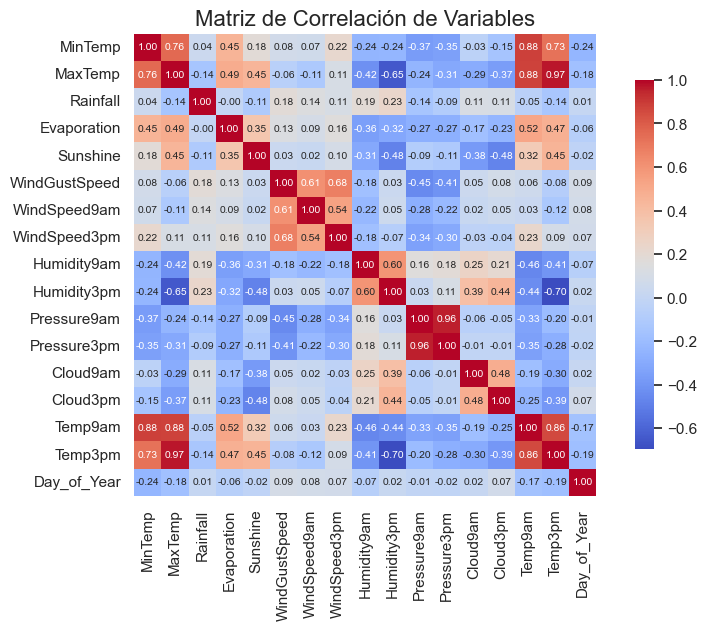

In [39]:
plt.figure(figsize=(10, 6))


sns.heatmap(X_train.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 7.5})

plt.title('Matriz de Correlación de Variables', fontsize=16)
plt.show()

Gracias a la matriz de correlacion, se pueden hacer algunas observaciones:
* MinTemp y MaxTemp: Hay una fuerte correlación positiva (0.80), lo que indica que si la temperatura mínima sube, es probable que la temperatura máxima también lo haga.

* Temp9am y Temp3pm: Hay una correlación casi perfecta (0.86) entre estas dos variables, lo que es esperable ya que las temperaturas en diferentes momentos del día suelen estar relacionadas.

* MinTemp y Temp9am: Tienen una correlación muy alta (0.91), lo que sugiere que la temperatura mínima registrada durante el día está muy ligada a la temperatura a las 9 de la mañana.

* MaxTemp y Temp3pm: También tienen una correlación muy alta (0.94), lo que indica que la temperatura máxima diaria tiende a estar cercana a la de las 3 pm.

* Pressure9am y Pressure3pm: La correlación es casi perfecta (0.96), lo que sugiere que la presión atmosférica no cambia mucho entre la mañana y la tarde.

* Cloud9am y Cloud3pm: La correlación (0.56) muestra que el porcentaje de nubosidad en la mañana tiende a predecir razonablemente bien la cantidad de nubosidad en la tarde.

In [40]:
# Aplanar la matriz de correlación y resetear los índices
correlation_pairs = X_train.select_dtypes(include=['number']).unstack().reset_index()

# Renombrar las columnas
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Eliminar las correlaciones duplicadas (diagonal y columnas)
correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]

# Ordenar por la mayor correlación positiva
correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Eliminar duplicados y valores nulos
correlation_pairs.drop_duplicates(subset=['Correlation'], inplace=True)
correlation_pairs.dropna(inplace=True)

# Resetear el índice
correlation_pairs.reset_index(drop=True, inplace=True)

# Mostrar las 10 pares de variables con mayor correlación positiva y las 10 pares de variables con mayor correlación negativa
print(correlation_pairs.head(10), '\n', correlation_pairs.tail(10))

    Variable 1  Variable 2  Correlation
0  Pressure9am       59106       1039.3
1  Pressure9am       78922       1039.2
2  Pressure9am       77191       1038.8
3  Pressure9am       77216       1038.7
4  Pressure9am       77964       1038.5
5  Pressure9am       80252       1038.3
6  Pressure9am       60804       1038.1
7  Pressure9am       76941       1038.0
8  Pressure9am       77243       1037.9
9  Pressure9am       75913       1037.8 
      Variable 1  Variable 2  Correlation
1377    MinTemp       54053         -7.0
1378    MinTemp       52694         -7.1
1379    Temp9am       54754         -7.2
1380    MinTemp       54755         -7.3
1381    MinTemp       54052         -7.5
1382    MinTemp       54043         -7.6
1383    MinTemp       54736         -7.8
1384    MinTemp       52637         -8.0
1385    MinTemp       54410         -8.2
1386    MinTemp       52254         -8.5


## Estandarizacion y escalado de datos ##

Gracias a los boxplots hechos anteriormente, podemos ver una cantidad de valores atipicos grande, entonces lo que mas nos conviene es usar un escalado robusto

# Punto 2

Implementar la solución del problema de clasificación con regresión logística.

## Weighted vs Balanced

In [41]:
logist_class_w = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_w.fit(X_train_encoded,y_train_encoded)
logist_class_b = make_pipeline(RobustScaler(), LogisticRegression(random_state=42, class_weight='balanced'))
logist_class_b.fit(X_train_encoded,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

### Matriz de Confusión Modelos W y B

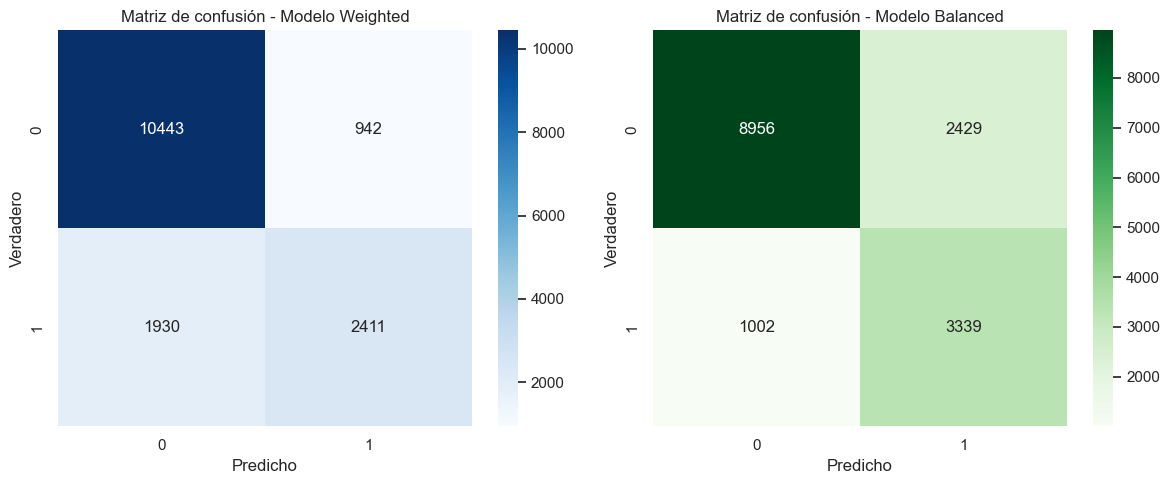

In [79]:
# Predecir las etiquetas en el conjunto de prueba o validación (usa el conjunto que prefieras)
y_train_pred_w = logist_class_w.predict(X_train_encoded)
y_train_pred_b = logist_class_b.predict(X_train_encoded)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train_encoded, y_train_pred_w)
cmb = confusion_matrix(y_train_encoded, y_train_pred_b)

# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap para la primera matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Weighted")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")

# Heatmap para la segunda matriz de confusión
sns.heatmap(cmb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Balanced")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [43]:
y_train_encoded.value_counts()

RainTomorrow
0    11385
1     4341
Name: count, dtype: int64

Definiendo clase Positiva a "Lluvia"

Modelo Weighted:
- Falsos Positivos: Hubo 942 días en los que se predijo que no iba a llover (0) y llovió (1).
- Falsos Negativos: Hubo 1.930 días en los que se predijo que iba a llover (1) y no llovió (0).

Modelo Balanced:
- Falsos Positivos: Hubo 2.429 días en los que se predijo que no iba a llover (0) y llovió (1)
- Falsos Negativos: Hubo 1.000 días en los que se predijo que iba a llover (1) y no llovió (0)

En el primer modelo (Weighted), tiene sentido que el dataset esté desbalanceado, con una mayor proporción de días en los que "No llueve" (0). Como se priorizó predecir correctamente los días en los que no llueve, se obtuvo un número alto de predicciones correctas para esta clase (11,282), con solo 744 días mal predichos (falsos positivos). Sin embargo, la clase "Llueve" (1) tuvo un desempeño inferior, con solo 1,950 días correctamente predichos y 1,750 días mal predichos (falsos negativos), lo que significa que la mitad de los días en los que llovió no fueron correctamente identificados.

En el segundo modelo (Balanced), al aplicar una penalización mayor a la clase con menos datos ("Llueve"), se logra disminuir significativamente la tasa de falsos negativos, reduciéndolos a 810. Sin embargo, el número de falsos positivos aumenta considerablemente, casi triplicándose a 2,354. Esto refleja que se ha logrado balancear las detecciones de ambas clases, pero a costa de aumentar los errores en los días que no llueve.

#### Vemos la diferencia en las metricas

In [44]:
# Calcular las métricas
metrics_train_w = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_w),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_w, pos_label=1),  # Precision para clase 1 (Llueve)
        recall_score(y_train_encoded, y_train_pred_w, pos_label=1),  # Recall para clase 1 (Llueve)
        f1_score(y_train_encoded, y_train_pred_w, pos_label=1),  # F1 Score para clase 1 (Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_w),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_w),  # Kappa (global)
        roc_auc_score(y_train_encoded, logist_class_w.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 1 (Llueve)
    ],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_w),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_w, pos_label=0),  # Precision para clase 0 (No Llueve)
        recall_score(y_train_encoded, y_train_pred_w, pos_label=0),  # Recall para clase 0 (No Llueve)
        f1_score(y_train_encoded, y_train_pred_w, pos_label=0),  # F1 Score para clase 0 (No Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_w),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_w),  # Kappa (global)
        1 - roc_auc_score(y_train_encoded, logist_class_w.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 0 (No Llueve)
    ]
}


In [45]:
# Convertir a DataFrame
df_metrics_train_w = pd.DataFrame(metrics_train_w)

# Mostrar el DataFrame
df_metrics_train_w

,Metricas,Llueve,No Llueve
0,Accuracy,0.817373,0.817373
1,Precision,0.719058,0.844015
2,Recall,0.555402,0.917260
3,F1 Score,0.626722,0.879114
4,MCC,0.515890,0.515890
5,Cohen's Kappa,0.508461,0.508461
6,AUC Roc,0.860877,0.139123


**Accuracy**

El accuracy general del modelo es relativamente alto (81.73%). Sin embargo, dado que las clases están desbalanceadas, esta métrica por sí sola no es suficiente para evaluar el rendimiento del modelo en detalle ya que se trata de un modelo desbalanceado.

**Precision**

- Para la clase "Llueve", la precisión es del 71.9%, lo que significa que, de todas las predicciones positivas (cuando se predijo que iba a llover), el 71.9% fueron realmente positivas. Esto indica que el modelo genera algunos falsos positivos.
- Para la clase "No Llueve", la precisión es alta, con un 84.4%, lo que sugiere que el modelo es más confiable al predecir los días en los que no llueve.

**Recall**

- El recall para "Llueve" es del 55.54%, lo que significa que el modelo solo identifica correctamente el 55.54% de los días en los que realmente llovió. Esto es preocupante porque indica que el modelo pierde una cantidad significativa de instancias de lluvia, lo que puede ser crítico en situaciones donde es importante predecir los días de lluvia.
- En contraste, el recall para "No Llueve" es muy alto, 91.72%, lo que sugiere que el modelo es efectivo para identificar los días en los que no llueve, aunque esto puede estar ocurriendo a expensas de la clase "Llueve".

**F1 Score**

- El F1 Score para la clase "Llueve" es de 62.67%, lo que refleja un rendimiento moderado del modelo en esta clase, equilibrando la precisión y el recall.
- Para la clase "No Llueve", el F1 Score es significativamente más alto, 87.91%, lo que muestra un mejor rendimiento del modelo para identificar correctamente los días sin lluvia.

**MCC (Matthews Correlation Coefficient)**

El MCC es 0.5158, lo que indica un rendimiento moderado del modelo. Esta métrica tiene en cuenta tanto verdaderos como falsos positivos y negativos, por lo que es útil en conjuntos de datos desbalanceados como este.
Cohen's Kappa:

**Kappa**

La puntuación de Cohen's Kappa es 0.5084, lo que indica un acuerdo moderado entre las predicciones del modelo y las etiquetas reales, sugiriendo que el modelo es mejor que uno aleatorio, pero aún con margen de mejora.
AUC-ROC:

**AUC-ROC**

El AUC-ROC es de 0.860877, lo que indica que el modelo tiene una capacidad razonablemente alta para diferenciar entre días de lluvia y días sin lluvia.


**Conclusión sobre el desbalance de clases**

El modelo tiene un buen rendimiento para la clase "No Llueve", pero sufre considerablemente con la clase "Llueve", como se refleja en el menor recall y F1 score. Esto es común en modelos que no están ajustados para manejar datos desbalanceados, y puede llevar a decisiones incorrectas en aplicaciones donde es crucial identificar los días de lluvia.

In [46]:
metrics_train_b = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
        'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_b),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_b, pos_label=1),  # Precision para clase 1 (Llueve)
        recall_score(y_train_encoded, y_train_pred_b, pos_label=1),  # Recall para clase 1 (Llueve)
        f1_score(y_train_encoded, y_train_pred_b, pos_label=1),  # F1 Score para clase 1 (Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_b),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_b),  # Kappa (global)
        roc_auc_score(y_train_encoded, logist_class_b.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 1 (Llueve)
    ],

    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_b),  # Accuracy (general)
        precision_score(y_train_encoded, y_train_pred_b, pos_label=0),  # Precision para clase 0 (No Llueve)
        recall_score(y_train_encoded, y_train_pred_b, pos_label=0),  # Recall para clase 0 (No Llueve)
        f1_score(y_train_encoded, y_train_pred_b, pos_label=0),  # F1 Score para clase 0 (No Llueve)
        matthews_corrcoef(y_train_encoded, y_train_pred_b),  # MCC (global)
        cohen_kappa_score(y_train_encoded, y_train_pred_b),  # Kappa (global)
        1- roc_auc_score(y_train_encoded, logist_class_b.predict_proba(X_train_encoded)[:, 1]) # AUC para clase 0 (No Llueve)
    ]
}


In [47]:
# Convertir a DataFrame
df_metrics_train_b = pd.DataFrame(metrics_train_b)

# Mostrar el DataFrame
df_metrics_train_b

,Metricas,Llueve,No Llueve
0,Accuracy,0.781826,0.781826
1,Precision,0.578883,0.899377
2,Recall,0.769178,0.786649
3,F1 Score,0.660599,0.839245
4,MCC,0.515587,0.515587
5,Cohen's Kappa,0.504521,0.504521
6,AUC Roc,0.861105,0.138895


**Accuracy**

El accuracy es 0.7818, lo cual, aunque es menor que el del modelo no balanceado, al tener penalidades balanceadas es un valor más "realista". Esto significa que el modelo está equilibrando mejor ambas clases.
Precision:

**Precisión**
- Para la clase "Llueve", la precisión es de 57.88%, lo que significa que un poco más de la mitad de las predicciones positivas (cuando el modelo predice lluvia) son correctas. Esta es una reducción significativa en comparación con el modelo no balanceado, lo que indica que el modelo está dispuesto a aceptar más falsos positivos para mejorar la capacidad de capturar los días lluviosos.
- Para la clase "No Llueve", la precisión sigue siendo alta, en 89.93%, lo que indica que el modelo sigue siendo muy confiable cuando predice que no va a llover.

**Recall**

- El recall para la clase "Llueve" es 76.91%, lo que significa que el modelo identifica correctamente la mayoría de los días en los que realmente llueve, mejorando considerablemente respecto al modelo no balanceado.
- Para la clase "No Llueve", el recall es 78.66%, menor que el del modelo no balanceado, pero sigue siendo bueno y muestra que el modelo sigue capturando adecuadamente la mayoría de los días sin lluvia.

**F1 Score**

- El F1 Score para "Llueve" es de 66.05%, lo que refleja un rendimiento moderado, equilibrando precisión y recall. Este valor es más alto que en el modelo no balanceado, lo que indica una mejora general en la capacidad del modelo para manejar la clase minoritaria ("Llueve").
- Para "No Llueve", el F1 Score es 83.92%, lo que sigue reflejando un excelente rendimiento para la clase mayoritaria.

**MCC (Matthews Correlation Coefficient)**

El MCC es 0.5155, lo que sugiere un rendimiento moderado. Aunque no es perfecto, esta métrica sigue siendo mejor que un rendimiento al azar y refleja un buen balance en el rendimiento del modelo para ambas clases.

**Cohen's Kappa**

La puntuación de Cohen's Kappa es 0.5045, lo que indica un acuerdo moderado entre las predicciones del modelo y las etiquetas reales. Este valor es similar al del modelo no balanceado, sugiriendo que hay margen de mejora en el acuerdo global.

**AUC-ROC**

El modelo tiene una AUC-ROC de 0.8611, similar al anterior.

##### Mejora en el Recall

El modelo balanceado muestra una mejora significativa en el recall para la clase "Llueve" en comparación con el modelo no balanceado. Esto significa que el modelo es más efectivo en identificar instancias de lluvia, lo cual es crítico en situaciones donde es importante no perder casos positivos (como predicciones de eventos climáticos adversos).

##### Compromiso entre Clases

La precisión de la clase "Llueve" ha disminuido en comparación con el modelo no balanceado, lo que indica que el modelo está dispuesto a aceptar más falsos positivos con el fin de mejorar su capacidad para identificar los días lluviosos. Este es un trade-off común en modelos balanceados y puede ser aceptable dependiendo del contexto del problema.

### Curva ROC modelos W y B

Trazar curvas ROC para cada modelo. Comenten cuáles serían los umbrales adecuados a utilizar; ¿cómo podrían calcular el mejor umbral? ¿Es 0.5 el mejor?

In [48]:
#Probabilidades de predicción modelo w
y_train_probs_w = logist_class_w.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_w, tpr_w, thresholds_w = roc_curve(y_train_encoded, y_train_probs_w)

roc_auc_w = auc(fpr_w, tpr_w)

#Probabilidades de predicción modelo b
y_train_probs_b = logist_class_b.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_b, tpr_b, thresholds_b = roc_curve(y_train_encoded, y_train_probs_b)

roc_auc_b = auc(fpr_b, tpr_b)

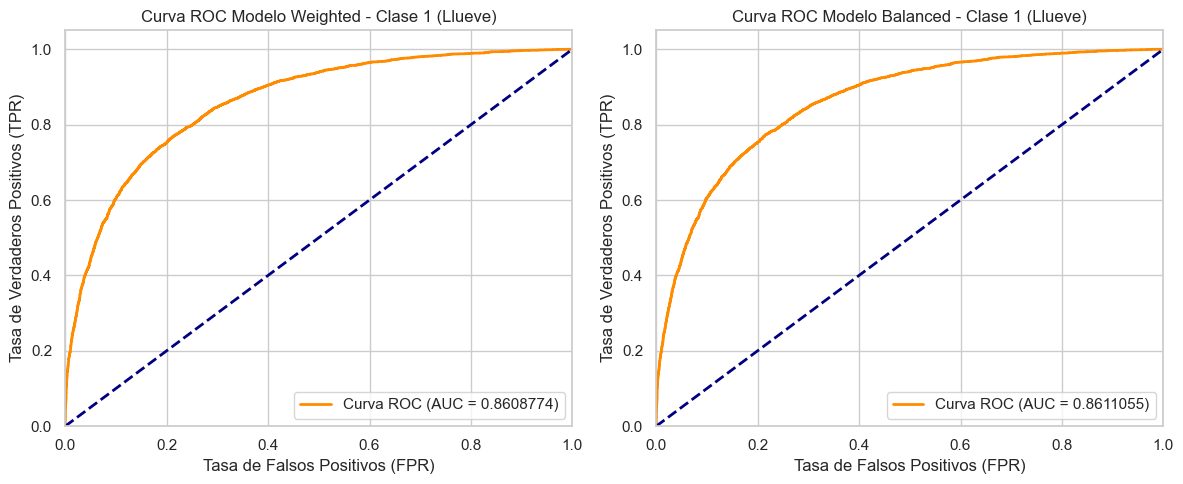

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC AUC para modelo Weighted (Clase 1: Llueve)
axes[0].plot(fpr_w, tpr_w, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc_w)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC Modelo Weighted - Clase 1 (Llueve)')
axes[0].legend(loc="lower right")

# Curva ROC AUC para modelo Balanced (Clase 1: Llueve)
axes[1].plot(fpr_b, tpr_b, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc_b)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC Modelo Balanced - Clase 1 (Llueve)')
axes[1].legend(loc="lower right")

# Ajustar el espaciado entre gráficos
plt.tight_layout()
plt.show()




##### Modelo Weighted.
- Clase 1 (Llueve):
    El AUC es 0.8608, lo que sugiere que el modelo ponderado tiene un buen rendimiento al predecir la clase "Llueve". La curva ROC está alejada de la diagonal, lo que indica que el modelo tiene una buena capacidad de distinguir entre "Llueve" y "No Llueve", con una baja tasa de falsos positivos y una alta tasa de verdaderos positivos.

##### Modelo Balanced
- Clase 0 (No Llueve):
    El AUC es 0.8611, casi idéntico al del modelo ponderado. Esto indica que el balanceo de las clases no ha mejorado el rendimiento del modelo en la predicción signidicativamente.


##### Conclusión general
El modelo tiene un rendimiento similar para predecir la clase "Llueve", tanto en la versión ponderada como balanceada, con un AUC alrededor de 0.86. 





#### Auc
El AUC (Área Bajo la Curva) es de 0.86 aproximada para ambas, lo cual es una buena señal ya que esta cerca de 1 (es decir, cerca de tener un buen poder de discriminación entre clases).
El mejor umbral se puede calcular como aquel punto en la curva ROC que tenga la menor distancia euclidiana al punto (1,0). 
0.5 generalmente suele ser un buen umbral para modelos balanceados, como este no es el caso, no sería el mejor umbral.

### Fitting Modelos W y B

El fitting no es el mejor, ya que hay una gran diferencia entre los verdaderos positivos de No Lluvia y los verdaderos negativos de No Lluvia. Esto puede deberse al mal balanceo de clases, a pesar de proponer el modelo balanced.

## Modelo Balanceado con Oversampling

In [50]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_encoded, y_train_encoded)

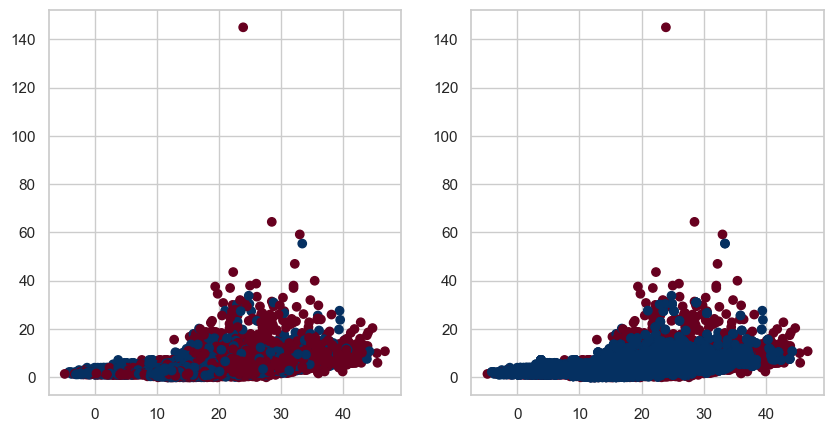

In [51]:
##Vemos la diferencia entre el original y el oversampled para dos columnas
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train_encoded['MaxTemp'], X_train_encoded['Evaporation'], c=y_train_encoded, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled['MaxTemp'], X_resampled['Evaporation'], c=y_resampled, cmap=plt.cm.RdBu)
plt.show()

### Modelo Logistic oversampled

In [52]:
logist_class_oversampled = make_pipeline(RobustScaler(), LogisticRegression(random_state = 9))

In [53]:
logist_class_oversampled.fit(X_resampled,y_resampled)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=9))])

In [54]:
y_train_pred_ov = logist_class_oversampled.predict(X_resampled)

### Matriz de confusión modelo oversampled

In [55]:
cm_ov = confusion_matrix(y_resampled, y_train_pred_ov)

### Heatmap para la segunda matriz de confusión

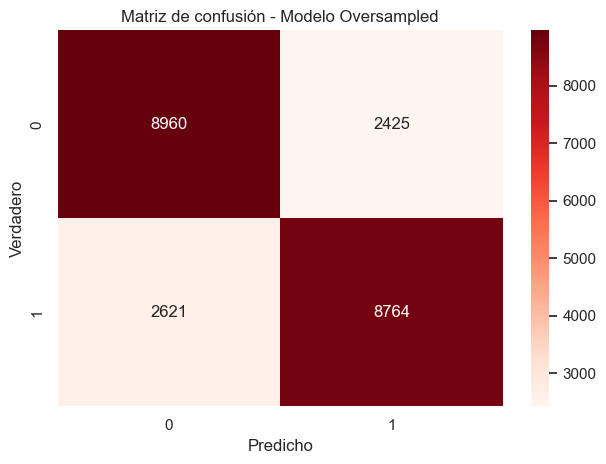

In [56]:
sns.heatmap(cm_ov, annot=True, fmt="d", cmap="Reds")
plt.title("Matriz de confusión - Modelo Oversampled")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Se ve que el modelo tiene una cantidad de falsos negativos similar al modelo balanced, sin embargo, hay que tener en cuenta los valores de las métricas ya que al hacer oversampling se estan agregando datos.
- Falsos Positivos: Hubo 2.415 días en los que se predijo que no iba a llover (0) y llovió (1). 
- Falsos Negativos: Hubo 2.621 días en los que se predijo que iba a llover (1) y no llovió (0). 


### Métricas modelo oversampled

In [57]:
# Calcular las métricas
metrics_train_ov = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
        'Llueve': [
        accuracy_score(y_resampled, y_train_pred_ov),  # Accuracy para clase 2
        precision_score(y_resampled, y_train_pred_ov, pos_label=1),  # Precision para clase 2
        recall_score(y_resampled, y_train_pred_ov, pos_label=1),  # Recall para clase 2
        f1_score(y_resampled, y_train_pred_ov, pos_label=1),  # F1 Score para clase 2
        matthews_corrcoef(y_resampled, y_train_pred_ov),  # MCC para clase 2
        cohen_kappa_score(y_resampled, y_train_pred_ov),  # Kappa para clase 2
        roc_auc_score(y_resampled, logist_class_b.predict_proba(X_resampled)[:, 1])  # AUC para clase 2
    ],

    'No Llueve': [
        accuracy_score(y_resampled, y_train_pred_ov),  # Accuracy para clase 1
        precision_score(y_resampled, y_train_pred_ov, pos_label=0),  # Precision para clase 1
        recall_score(y_resampled, y_train_pred_ov, pos_label=0),  # Recall para clase 1
        f1_score(y_resampled, y_train_pred_ov, pos_label=0),  # F1 Score para clase 1
        matthews_corrcoef(y_resampled, y_train_pred_ov),  # MCC para clase 1
        cohen_kappa_score(y_resampled, y_train_pred_ov),  # Kappa para clase 1
        roc_auc_score(y_resampled, logist_class_b.predict_proba(X_resampled)[:, 0])  # AUC para clase 1
    ]
}

## Comparación modelo Weighted, Balanced y Oversampled

In [58]:
df_metrics_train_ov = pd.DataFrame(metrics_train_ov)
df_metrics_train_ov

,Metricas,Llueve,No Llueve
0,Accuracy,0.778393,0.778393
1,Precision,0.783269,0.773681
2,Recall,0.769785,0.787000
3,F1 Score,0.776469,0.780284
4,MCC,0.556868,0.556868
5,Cohen's Kappa,0.556785,0.556785
6,AUC Roc,0.859915,0.140085


In [59]:
df_metrics_train_w

,Metricas,Llueve,No Llueve
0,Accuracy,0.817373,0.817373
1,Precision,0.719058,0.844015
2,Recall,0.555402,0.917260
3,F1 Score,0.626722,0.879114
4,MCC,0.515890,0.515890
5,Cohen's Kappa,0.508461,0.508461
6,AUC Roc,0.860877,0.139123


In [60]:
df_metrics_train_b

,Metricas,Llueve,No Llueve
0,Accuracy,0.781826,0.781826
1,Precision,0.578883,0.899377
2,Recall,0.769178,0.786649
3,F1 Score,0.660599,0.839245
4,MCC,0.515587,0.515587
5,Cohen's Kappa,0.504521,0.504521
6,AUC Roc,0.861105,0.138895


Se puede ver que entre los 3 modelos, aquel que tiene una mayor consistencia para ambas clases es el oversampled; se ve que tiene un MCC de 0.5568 lo que indica que teien un rendimiento global más consistente entre clases, como así tambien obtiene el mejor resultado en Cohen's Kappa (0.5567), indicando mejor acuerdo entre el modelo y la etiqueta verdadera comparado con los otros dos modelos.

Conclusión General:
- Modelo Oversampled: Tiene un buen balance entre precisión y recall, con un MCC y Kappa ligeramente superiores. Si se busca un modelo que tenga un desempeño estable entre ambas clases, este modelo parece una buena opción.
- Modelo Weighted: Es excelente para predecir "No Llueve" (alta precisión, recall y F1 score para esa clase), pero sufre bastante en la predicción de "Llueve", con un recall bajo (55.54%).
- Modelo Balanced: Mantiene un equilibrio intermedio, destacando en precisión para "No Llueve" (89.93%) y con un recall mejorado para "Llueve" (76.91%), pero su precisión para "Llueve" es más baja (57.88%).


Cada modelo tiene sus fortalezas según la clase en la que se quiera enfocar. El modelo oversampled parece el más balanceado, pero el weighted puede ser útil si la clase "No Llueve" es más importante para el objetivo.

### Curva ROC - AUC para modelo oversampled

In [61]:
#Probabilidades de predicción modelo oversampled
y_train_probs_ov = logist_class_oversampled.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC para clase No Llueve
fpr_ov, tpr_ov, thresholds_ov = roc_curve(y_train_encoded, y_train_probs_ov)

roc_auc_ov = auc(fpr_ov, tpr_ov)

# Curva ROC AUC para la clase Llueve
fpr_ov_no_llueve, tpr_ov_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_ov)
roc_auc_no_ov_llueve = auc(fpr_ov_no_llueve, tpr_ov_llueve)

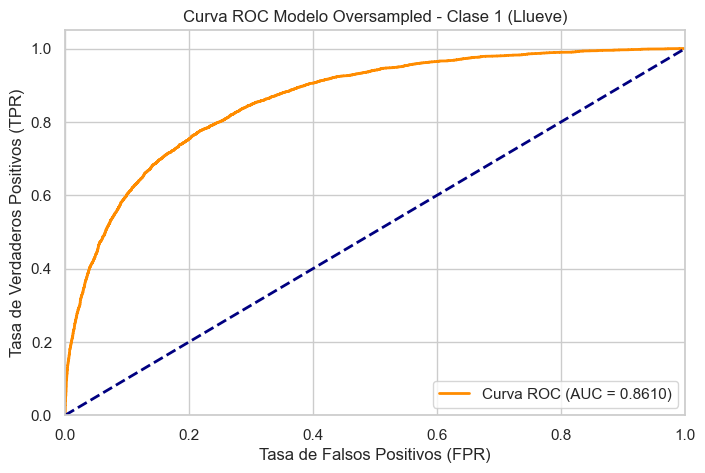

In [94]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
# Curva ROC AUC para modelo Oversampled (Clase 1: Llueve)
axes.plot(fpr_ov, tpr_ov, color='darkorange', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_ov)
axes.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('Tasa de Falsos Positivos (FPR)')
axes.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes.set_title('Curva ROC Modelo Oversampled - Clase 1 (Llueve)')
axes.legend(loc="lower right")


Los tres modelos tienen AUCs casi idénticas para ambas clases. Lo que sugiere que los tres modelos tienen similar capacidad para discriminar entre las clases.

### Métrica elegida para evaluar.

Se elige la métrica 'F1-Score' en especial para la clase 1 (Llueve) ya que nos interesa que el modelo prediga de manera óptima esta clase.

### Fitting modelo oversampled

In [96]:
df_metrics_train_ov

,Metricas,Llueve,No Llueve
0,Accuracy,0.778393,0.778393
1,Precision,0.783269,0.773681
2,Recall,0.769785,0.787000
3,F1 Score,0.776469,0.780284
4,MCC,0.556868,0.556868
5,Cohen's Kappa,0.556785,0.556785
6,AUC Roc,0.859915,0.140085


Siguiendo con el interés de que el modelo prediga bien los días que llueve, se obtiene un buen fitting en relación a la métrica de interés F1-Score y de las que esta nace (Recall y Precisión).
Esto quiere decir que dentro de la clase Lluvia, el 0.7697 fueron bien clasificadas (Recall); de las que fueron clasificadas como lluvia, el 0.7832 realmente lo eran (Precisión) y la media armónica entre ambos (F1-Score) también da una medida buena (0.7764). 

# Punto 3

### Modelo Base 1: regresión lineal

In [63]:
X_train_regresion = X_train_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_val_regresion = X_val_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_test_regresion = X_test_encoded[['MaxTemp', 'Temp3pm', 'Temp9am']]


In [64]:
model_linear_R = make_pipeline(RobustScaler(),LinearRegression())
model_linear_R.fit(X_train_regresion, y_train_encoded)

# Paso 2: Validar el modelo con el conjunto de validación

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [65]:
## Predicciones
y_train_pred_lr = model_linear_R.predict(X_train_regresion)
y_val_pred_lr = model_linear_R.predict(X_val_regresion)
y_test_pred_lr = model_linear_R.predict(X_test_regresion)

In [66]:

mse_train_lr = mean_squared_error(y_train_encoded, y_train_pred_lr)
r2_train_lr = r2_score(y_train_encoded, y_train_pred_lr)


mse_val = mean_squared_error(y_val_encoded, y_val_pred_lr)
r2_val = r2_score(y_val_encoded, y_val_pred_lr)

mse_test = mean_squared_error(y_test_encoded, y_test_pred_lr)
r2_test = r2_score(y_test_encoded, y_test_pred_lr)


# Convertir las predicciones continuas a etiquetas binarias con un umbral de 0.5
y_train_pred_discreto= [1 if pred >= 0.5 else 0 for pred in y_train_pred_lr]
y_val_pred_discreto= [1 if pred >= 0.5 else 0 for pred in y_val_pred_lr]
y_test_pred_discreto = [1 if pred >= 0.5 else 0 for pred in y_test_pred_lr]

### Modelo Base 1: Regresión Logística.

In [67]:
logist_class_regresion = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_regresion.fit(X_train_regresion,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [68]:
# Predecimos las etiquetas en el conjunto de validacion
y_train_pred_regresion = logist_class_regresion.predict(X_train_regresion)


### Modelo base 2: moda

In [69]:
#Hacemos la moda a nivel global ya que por mes, la moda en todos es 'NO'
moda = y_train_encoded.mode()[0]
y_pred_moda = [moda] * len(y_train_encoded)

### Modelo base 3: random

In [70]:
np.random.seed(42)
y_pred_random = np.random.choice(y_train_encoded.unique(), size=len(y_train_encoded))

In [71]:
regresion_metricas_test = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_regresion),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_train_pred_regresion, pos_label=0),  # Precision para clase 1
        recall_score(y_train_encoded, y_train_pred_regresion, pos_label=0),  # Recall para clase 1
        f1_score(y_train_encoded, y_train_pred_regresion, pos_label=0),  # F1 Score para clase 1
        roc_auc_score(y_train_encoded, y_train_pred_regresion)  # AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_regresion),  # Accuracy para clase 2
        precision_score(y_train_encoded, y_train_pred_regresion, pos_label=1),  # Precision para clase 2
        recall_score(y_train_encoded, y_train_pred_regresion, pos_label=1),  # Recall para clase 2
        f1_score(y_train_encoded, y_train_pred_regresion, pos_label=1),  # F1 Score para clase 2
        roc_auc_score(y_train_encoded, y_train_pred_regresion)  # AUC para clase 2
    ]
}

In [72]:
regresion_metricas_df = pd.DataFrame(regresion_metricas_test)
regresion_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.742338,0.742338
1,Precision,0.747753,0.655879
2,Recall,0.971981,0.140060
3,F1 Score,0.845249,0.230828
4,AUC Roc,0.556020,0.556020


In [73]:
random_metricas = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_pred_random),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_pred_random, pos_label=0),  # Precision para clase 1
        recall_score(y_train_encoded, y_pred_random, pos_label=0),  # Recall para clase 1
        f1_score(y_train_encoded, y_pred_random, pos_label=0),  # F1 Score para clase 1
        roc_auc_score(y_train_encoded, y_pred_random)# AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_train_encoded, y_pred_random),  # Accuracy para clase 2
        precision_score(y_train_encoded, y_pred_random, pos_label=1),  # Precision para clase 2
        recall_score(y_train_encoded, y_pred_random, pos_label=1),  # Recall para clase 2
        f1_score(y_train_encoded, y_pred_random, pos_label=1),  # F1 Score para clase 2
        roc_auc_score(y_train_encoded, y_pred_random)# AUC para clase 2
    ]
}

In [74]:
random_metricas_df = pd.DataFrame(random_metricas)
random_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.496248,0.496248
1,Precision,0.719039,0.271065
2,Recall,0.499253,0.488367
3,F1 Score,0.589321,0.348627
4,AUC Roc,0.493810,0.493810


In [75]:
moda_metricas = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_pred_moda),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_pred_moda, pos_label=0),  # Precision para clase 1
        recall_score(y_train_encoded, y_pred_moda, pos_label=0),  # Recall para clase 1
        f1_score(y_train_encoded, y_pred_moda, pos_label=0),  # F1 Score para clase 1
        roc_auc_score(y_train_encoded, y_pred_moda)# AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_train_encoded, y_pred_moda),  # Accuracy para clase 2
        precision_score(y_train_encoded, y_pred_moda, pos_label=1),  # Precision para clase 2
        recall_score(y_train_encoded, y_pred_moda, pos_label=1),  # Recall para clase 2
        f1_score(y_train_encoded, y_pred_moda, pos_label=1),  # F1 Score para clase 2
        roc_auc_score(y_train_encoded, y_pred_moda)# AUC para clase 2
    ]
}


In [76]:
moda_metricas_df = pd.DataFrame(moda_metricas)
moda_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.72396,0.72396
1,Precision,0.72396,0.00000
2,Recall,1.00000,0.00000
3,F1 Score,0.83988,0.00000
4,AUC Roc,0.50000,0.50000


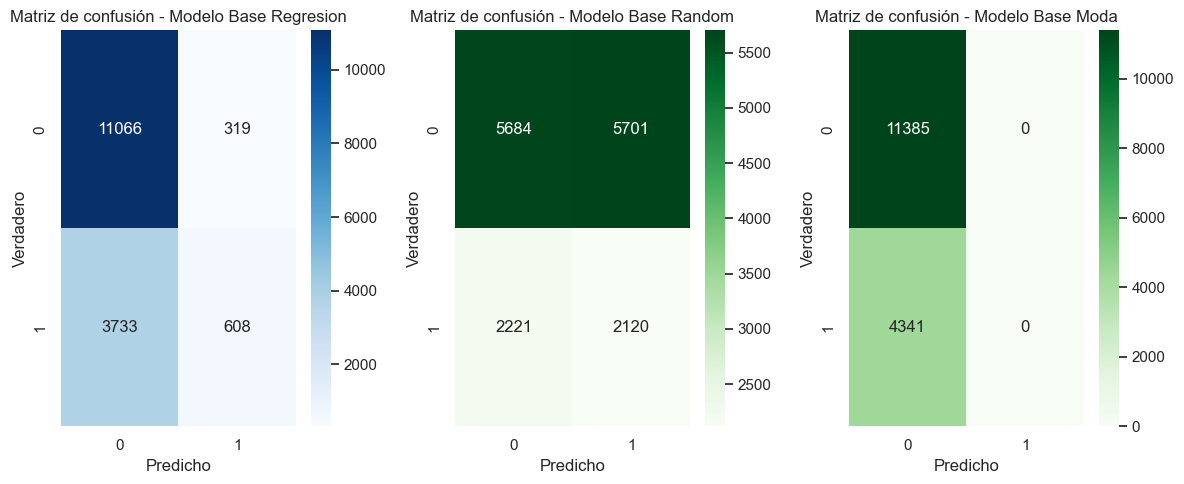

In [77]:
randomm = confusion_matrix(y_train_encoded, y_pred_random)
moda = confusion_matrix(y_train_encoded, y_pred_moda)
cm_regresion = confusion_matrix(y_train_encoded, y_train_pred_regresion)

# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(12, 5))


# Heatmap para la primera matriz de confusión
sns.heatmap(cm_regresion, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Base Regresion")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")


# Heatmap para la segunda matriz de confusión
sns.heatmap(randomm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Base Random")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Heatmap para la tercera matriz de confusión
sns.heatmap(moda, annot=True, fmt="d", cmap="Greens", ax=axes[2])
axes[2].set_title("Matriz de confusión - Modelo Base Moda")
axes[2].set_xlabel("Predicho")
axes[2].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Modelo Base por Regresion:
Accuracy:0.77 para las dos clases, lo que indica un rendimiento mejor que un modelo aleatorio. El modelo es capaz de predecir correctamente el 77% de las instancias en total.

Precision:0.777 para "No Llueve": El modelo predice correctamente que no llueve el 77.7% de las veces que hace esta predicción. 0.589 para "Llueve": predice correctamente que lloverá el 58.9% de las veces.

Recall:0.981 para "No Llueve": Detecta correctamente el 98.1% de los casos en los que realmente no llueve. 0.084 para "Llueve": Solo identifica correctamente el 8.4% de los días en los que realmente llueve, lo que sugiere que el modelo tiene grandes problemas para detectar esta clase.

F1 Score: 0.867 para "No Llueve": El equilibrio entre precisión y recall para la clase "No Llueve" es bastante bueno. 0.147 para "Llueve": El F1 Score para la clase "Llueve" es extremadamente bajo, lo que confirma la falta de detección de los días de lluvia.

AUC Roc: 0.533 para las dos clases, lo que sugiere que el modelo no puede identificar cuando"Llueve".

### Modelo Base Aleatorio:
Accuracy: 50.1% de precisión para las dos clases, lo que significa que es apenas mejor que el azar.

Precision: 0.764 "No Llueve" 0.234 "Llueve". Esto significa que el modelo predice bien el 76.4% de las veces correctamente cuando llueve y un 23.4% cuando no llueve.

Recall: 0.502 "No Llueve", 0.496 "Llueve". Esto indica que el modelo está capturando el 50.2% de los verdaderos positivos para "No Llueve" y el 49.6% para "Llueve".

F1 Score: El F1 Score de 0.606 para "No Llueve" y 0.31 para "Llueve" muestra un equilibrio entre precisión y recall, siendo más alto para "No Llueve".

AUC Roc: 0.499 para las dos clases, lo que muestra que el modelo tiene un muy parecido al azar.

### Modelo Base por Moda:
Accuracy: 0.764 para las dos clases,  El modelo es capaz de predecir correctamente el 76.4% de las instancias en total.

Precision: 0.764 para "No Llueve" y 0.000 para "Llueve". Esto significa que el modelo predice bien el 76.4% de las veces correctamente cuando llueve y 0% cuando no llueve.

Recall: 1.000 "No Llueve", 0.000 "Llueve", detecta todos los "No Llueve", pero ningún "Llueve".  Esto indica que el modelo está capturando el 100% de los verdaderos positivos para "No Llueve" y el 0% para "Llueve".

F1 Score: 0.866 "No Llueve", 0.000 "Llueve", lo que significa que falta de detección para "Llueve".  Indica un buen rendimiento del modelo en la clase "No llueve", reflejando un buen equilibrio entre precisión y recall. Mientras que no detecta en absoluto a cuando "Llueve".

AUC Roc: 0.500 para las dos clases, lo que sugiere que el modelo no puede identificar cuando"Llueve".


### Desempeño del Modelo:

El modelo de regresion tiene un buen desempeño para predecir la clase "No Llueve", con alta precisión, recall y F1 Score, pero es casi incapaz de predecir correctamente los días de "Llueve". Las métricas de precisión, recall y F1 para "Llueve" son todas extremadamente bajas, lo que sugiere que el modelo necesita ser ajustado o mejorado para manejar mejor esta clase minoritaria.

Al igual que un modelo basado en la moda (que predice siempre "No Llueve"), este modelo también tiene problemas con la detección de los días de lluvia, aunque tiene un rendimiento decente para la clase mayoritaria.

Y por ultimo podemos notar que el modelo aleatorio tiene un rendimiento muy bajo, ya que no puede encontrar relaciones en los datos.